In [2]:
%%configure -f 
{
    "conf":
    {
        "spark.app.name":"Bhavesh_Relevancy_notebook",
        "spark.yarn.queue": "workflow",
        "spark.jars": "/apps/Jars/obelisk-retail-legos.jar",
        "spark.driver.extraJavaOptions": "-Dscala.color",
        "spark.driver.memory": "4g",
        "spark.executor.memory": "4g",
        "spark.executor.instances": "4"
    }
}

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
652,application_1681204775733_1877,spark,idle,Link,Link,


In [1]:
!kinit -kt $KRB5_CLIENT_KTNAME $KRB5_PRINCIPAL

In [3]:
import ai.couture.obelisk.commons.Constants.STANDARD_COL_NAMES._
import ai.couture.obelisk.commons.Constants._
import ai.couture.obelisk.commons.io._
import ai.couture.obelisk.commons.utils.DateTimeUtil._
import org.apache.spark.sql._
import org.apache.spark.sql.expressions._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.catalyst.expressions._
import ai.couture.obelisk.commons.utils.DataFrameUtil.union

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
654,application_1681204775733_1900,spark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import ai.couture.obelisk.commons.Constants.STANDARD_COL_NAMES._
import ai.couture.obelisk.commons.Constants._
import ai.couture.obelisk.commons.io._
import ai.couture.obelisk.commons.utils.DateTimeUtil._
import org.apache.spark.sql._
import org.apache.spark.sql.expressions._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.catalyst.expressions._
import ai.couture.obelisk.commons.utils.DataFrameUtil.union


In [30]:
var df = CSVToDF.getDF("/data/Archive/plp/bhavesh/experiments/ajioplp_2023-04-17/PLPResultsEvaluation/2023-04-18/RankingComparisonMetrics/RankwiseProductDistributionDF/brickname/ranking=Combined")
DFToCSV.putDF("/data/Archive/plp/bhavesh/files/temp/metrics", df.coalesce(1))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

df: org.apache.spark.sql.DataFrame = [Algorithm: string, clusterid: string ... 3 more fields]


In [3]:
def putDFMultiColumnPartition(filepath: String, df: DataFrame, partitionedColumns: Seq[String]): Unit = {

df.repartition(partitionedColumns.map(col): _*)
  .write
  .option("header", "true")
  .option("delimiter", ",")
  .option("escape", "\\")
  .mode(SaveMode.Overwrite)
  .partitionBy(partitionedColumns: _*)
  .csv(filepath)

}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

putDFMultiColumnPartition: (filepath: String, df: org.apache.spark.sql.DataFrame, partitionedColumns: Seq[String])Unit


In [4]:
def putDFMultiColumnPartitionParquet(filepath: String, df: DataFrame, partitionedColumns: Seq[String]): Unit = {

df.repartition(partitionedColumns.map(col): _*)
  .write
  .mode(SaveMode.Overwrite)
  .partitionBy(partitionedColumns: _*)
  .parquet(filepath)

}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

putDFMultiColumnPartitionParquet: (filepath: String, df: org.apache.spark.sql.DataFrame, partitionedColumns: Seq[String])Unit


In [20]:
val numBins = 10
val k = Array(100, 1000, 5000, 10000)
val historyNDays = 30

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

numBins: Int = 10
k: Array[Int] = Array(100, 1000, 5000, 10000)
historyNDays: Int = 30


In [21]:
import org.apache.spark.ml.feature.Bucketizer
val bins = (0 to 100 by 100/numBins).map(_/1.0).toArray
val binsDF = bins.dropRight(1).toSeq.toDF("percentile_lower_bound").withColumn("binid", row_number().over(Window.orderBy("percentile_lower_bound")) - lit(1.0)).withColumn("percentile_upper_bound", (col("binid")+lit(1.0))*(lit(100.0/numBins))).crossJoin(k.toSeq.toDF("k"))
val bucketizer = new Bucketizer().setInputCol("percentile").setOutputCol("binid").setSplits(bins)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import org.apache.spark.ml.feature.Bucketizer
bins: Array[Double] = Array(0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0)
binsDF: org.apache.spark.sql.DataFrame = [percentile_lower_bound: double, binid: double ... 2 more fields]
bucketizer: org.apache.spark.ml.feature.Bucketizer = bucketizer_3953068433c9


In [22]:
binsDF.show(false)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+-----+----------------------+-----+
|percentile_lower_bound|binid|percentile_upper_bound|k    |
+----------------------+-----+----------------------+-----+
|0.0                   |0.0  |10.0                  |100  |
|0.0                   |0.0  |10.0                  |1000 |
|0.0                   |0.0  |10.0                  |5000 |
|0.0                   |0.0  |10.0                  |10000|
|10.0                  |1.0  |20.0                  |100  |
|10.0                  |1.0  |20.0                  |1000 |
|10.0                  |1.0  |20.0                  |5000 |
|10.0                  |1.0  |20.0                  |10000|
|20.0                  |2.0  |30.0                  |100  |
|20.0                  |2.0  |30.0                  |1000 |
|20.0                  |2.0  |30.0                  |5000 |
|20.0                  |2.0  |30.0                  |10000|
|30.0                  |3.0  |40.0                  |100  |
|30.0                  |3.0  |40.0      

In [23]:
var newProds = ParquetToDF.getDF("/data/Archive/plp/bhavesh/experiments/ajioplp_2023-04-17/lowExposureProductsInfo")
newProds.printSchema

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

newProds: org.apache.spark.sql.DataFrame = [productid: string, Algorithm: string ... 1 more field]
root
 |-- productid: string (nullable = true)
 |-- Algorithm: string (nullable = true)
 |-- clusterid: string (nullable = true)



In [24]:
var testDate = "2023-04-17"
var upperBoundDate = getOldDateFromHere(1, testDate, "yyyy-MM-dd")
var lowerBoundDate = getOldDateFromHere(historyNDays, testDate, "yyyy-MM-dd")
var gaData = ParquetToDF.getDF("/data/ecomm/ajio/processed/GaCohortVisibilityLegosFNL").filter(col(DATE).between(lowerBoundDate, upperBoundDate)).withColumn(ALGORITHM, lit("AjioPremiumClusteringlr"))
gaData = union(gaData, ParquetToDF.getDF("/data/ecomm/ajio/processed/ProcessedGAData").filter(col(DATE).between(lowerBoundDate, upperBoundDate)).withColumn(ALGORITHM, lit("AjioGlobalRankinglr")).withColumn(CLUSTERID, lit("cluster0")))
gaData = gaData.groupBy(PRODUCTID, ALGORITHM, CLUSTERID).agg(sum("PLPViewsPerDay") as "PLPViewsPerDay")
// var ranking = ParquetToDF.getDF(s"/data/Archive/plp/bhavesh/experiments/ajioplp_${testDate}/perclusterProductRank")
var ranking = ParquetToDF.getDF(s"/data/Archive/plp/bhavesh/experiments/ajioplp_${testDate}/perclusterProductRank")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

testDate: String = 2023-04-17
upperBoundDate: String = 2023-04-16
lowerBoundDate: String = 2023-03-18
gaData: org.apache.spark.sql.DataFrame = [productid: string, clusterid: string ... 7 more fields]
gaData: org.apache.spark.sql.DataFrame = [productid: string, clusterid: string ... 7 more fields]
gaData: org.apache.spark.sql.DataFrame = [productid: string, Algorithm: string ... 2 more fields]
ranking: org.apache.spark.sql.DataFrame = [productid: string, brickid: string ... 4 more fields]


In [25]:
var df = ranking.join(gaData, Seq(PRODUCTID, ALGORITHM, CLUSTERID), "left").na.fill(0).select(PRODUCTID, ALGORITHM, CLUSTERID, BRICKID, "PLPViewsPerDay", PRODUCTRANK)
DFToParquet.putDF("/data/Archive/plp/bhavesh/temp/rankingJoinedGA", df)
df = ParquetToDF.getDF("/data/Archive/plp/bhavesh/temp/rankingJoinedGA")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

df: org.apache.spark.sql.DataFrame = [productid: string, Algorithm: string ... 4 more fields]
df: org.apache.spark.sql.DataFrame = [productid: string, Algorithm: string ... 4 more fields]


In [26]:
df.printSchema

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- productid: string (nullable = true)
 |-- Algorithm: string (nullable = true)
 |-- clusterid: string (nullable = true)
 |-- brickid: string (nullable = true)
 |-- PLPViewsPerDay: double (nullable = true)
 |-- productrank: integer (nullable = true)



In [11]:
/** Define percentiles */
// Execute only once.
var df = ParquetToDF.getDF("/data/Archive/plp/bhavesh/temp/rankingJoinedGA")
df = df.withColumn("rank", row_number().over(Window.partitionBy(ALGORITHM, CLUSTERID, BRICKID).orderBy("PLPViewsPerDay")))
val cnt1 = df.count
df = df.join(df.groupBy(ALGORITHM, CLUSTERID, BRICKID).agg(max("rank") as "maxrank"), Seq(ALGORITHM, CLUSTERID, BRICKID))
val cnt2 = df.count
assert(cnt1 == cnt2, "count must match")
df = df.withColumn("percentile", (col("rank")/col("maxrank"))*lit(100)).select(PRODUCTID, ALGORITHM, CLUSTERID, BRICKID, "PLPViewsPerDay", PRODUCTRANK, "percentile")
DFToParquet.putDF(s"/data/Archive/plp/bhavesh/experiments/ajioplp_${testDate}/Analysis/percentilesBrickWise", df.select(PRODUCTID, ALGORITHM, CLUSTERID, BRICKID, "percentile"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

df: org.apache.spark.sql.DataFrame = [productid: string, Algorithm: string ... 4 more fields]
df: org.apache.spark.sql.DataFrame = [productid: string, Algorithm: string ... 5 more fields]
cnt1: Long = 4105518
df: org.apache.spark.sql.DataFrame = [Algorithm: string, clusterid: string ... 6 more fields]
cnt2: Long = 4105518
df: org.apache.spark.sql.DataFrame = [productid: string, Algorithm: string ... 5 more fields]


In [27]:
var df = ParquetToDF.getDF("/data/Archive/plp/bhavesh/temp/rankingJoinedGA")
val percentiles = ParquetToDF.getDF(s"/data/Archive/plp/bhavesh/experiments/ajioplp_${testDate}/Analysis/percentilesBrickWise")
val cnt1 = df.count
df = df.join(percentiles, Seq(PRODUCTID, ALGORITHM, CLUSTERID, BRICKID))
val cnt2 = df.count
assert(cnt1==cnt2, "count must be same")
var discretized_df = bucketizer.transform(df)
discretized_df = k.map(x=> discretized_df.filter(col(PRODUCTRANK)<=x).withColumn("k", lit(x))).reduce(_.union(_)).groupBy(ALGORITHM, CLUSTERID, "k", "binid").agg(countDistinct(PRODUCTID) as "count")
val algo_cluster = discretized_df.select(ALGORITHM, CLUSTERID).distinct()
discretized_df = binsDF.crossJoin(algo_cluster).join(discretized_df, Seq(ALGORITHM, CLUSTERID, "binid", "k"), "left").na.fill(0.0).drop("binid")
DFToCSV.putDF(s"/data/Archive/plp/bhavesh/experiments/ajioplp_${testDate}/Analysis/binnedData", discretized_df.coalesce(1))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

df: org.apache.spark.sql.DataFrame = [productid: string, Algorithm: string ... 4 more fields]
percentiles: org.apache.spark.sql.DataFrame = [productid: string, Algorithm: string ... 3 more fields]
cnt1: Long = 4105518
df: org.apache.spark.sql.DataFrame = [productid: string, Algorithm: string ... 5 more fields]
cnt2: Long = 4105518
discretized_df: org.apache.spark.sql.DataFrame = [productid: string, Algorithm: string ... 6 more fields]
discretized_df: org.apache.spark.sql.DataFrame = [Algorithm: string, clusterid: string ... 3 more fields]
algo_cluster: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [Algorithm: string, clusterid: string]
discretized_df: org.apache.spark.sql.DataFrame = [Algorithm: string, clusterid: string ... 4 more fields]


### Old Way of binning

In [10]:
val percentiles = (0 to 100 by 100/numBins).map(_/100.0).toArray
val percentileCols = percentiles.map(p => callUDF("percentile", col("PLPViewsPerDay"), lit(p)).alias(s"${(p*100).toInt}'th percentile"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

percentiles: Array[Double] = Array(0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0)
percentileCols: Array[org.apache.spark.sql.Column] = Array(percentile(PLPViewsPerDay, 0.0) AS `0'th percentile`, percentile(PLPViewsPerDay, 0.1) AS `10'th percentile`, percentile(PLPViewsPerDay, 0.2) AS `20'th percentile`, percentile(PLPViewsPerDay, 0.3) AS `30'th percentile`, percentile(PLPViewsPerDay, 0.4) AS `40'th percentile`, percentile(PLPViewsPerDay, 0.5) AS `50'th percentile`, percentile(PLPViewsPerDay, 0.6) AS `60'th percentile`, percentile(PLPViewsPerDay, 0.7) AS `70'th percentile`, percentile(PLPViewsPerDay, 0.8) AS `80'th percentile`, percentile(PLPViewsPerDay, 0.9) AS `90'th percentile`, percentile(PLPViewsPerDay, 1.0) AS `100'th percentile`)


In [11]:
import org.apache.spark.ml.feature.{QuantileDiscretizer, Bucketizer}
val groups = df.select(ALGORITHM, CLUSTERID, BRICKID).distinct().collect().map(row => (row.getAs[String](ALGORITHM), row.getAs[String](CLUSTERID), row.getAs[String](BRICKID)))
print(groups(0))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import org.apache.spark.ml.feature.{QuantileDiscretizer, Bucketizer}
groups: Array[(String, String, String)] = Array((AjioPremiumClusteringlr,cluster1,830311001), (AjioPremiumClusteringlr,cluster1,830207010), (AjioPremiumClusteringlr,cluster1,831102002), (AjioPremiumClusteringlr,cluster1,830307010), (AjioPremiumClusteringlr,cluster1,830216005), (AjioPremiumClusteringlr,cluster1,830605006), (AjioPremiumClusteringlr,cluster1,830211004), (AjioPremiumClusteringlr,cluster1,830316005), (AjioPremiumClusteringlr,cluster1,830306001), (AjioPremiumClusteringlr,cluster1,830603002), (AjioPremiumClusteringlr,cluster1,830212001), (AjioPremiumClusteringlr,cluster1,831206001), (AjioPremiumClusteringlr,cluster1,830216009), (AjioPremiumClusteringlr,cluster1,830710011), (AjioPremiumClusteringlr,cluster1,831202005), (AjioPremiumClusteringlr,cluster1...(AjioPremiumClusteringlr,cluster1,830311001)

In [12]:
groups.length

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res4: Int = 548


In [13]:
val discretized_df = groups.map(group => {
    val algo = group._1
    val cluster = group._2
    val brick = group._3
    val filtered_df = df.filter(col(ALGORITHM) === algo && col(CLUSTERID) === cluster && col(BRICKID) === brick)
//     val bins = filtered_df.agg(percentileCols.head, percentileCols.tail: _*).head().toSeq.map(_.asInstanceOf[Double]).toArray
//     val bucketizer = new Bucketizer().setInputCol("PLPViewsPerDay").setOutputCol("binid").setSplits(bins)
//     val splits = bucketizer.getSplits
//     DFToCSV.putDF(s"/data/Archive/plp/bhavesh/experiments/ajioplp_${testDate}/Analysis/binSplits/Algorithm=$algo/clusterid=$cluster",splits.toSeq.toDF("bins").coalesce(1))
//     DFToParquet.putDF(s"/data/Archive/plp/bhavesh/experiments/ajioplp_${testDate}/AnalysisParquet/binSplits/Algorithm=$algo/clusterid=$cluster",splits.toSeq.toDF("bins").coalesce(1))
    val bucketizer = new QuantileDiscretizer().setInputCol("PLPViewsPerDay").setOutputCol("binid").setNumBuckets(10)
    bucketizer.fit(filtered_df).transform(filtered_df)
}).reduce(_.union(_))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

discretized_df: org.apache.spark.sql.DataFrame = [productid: string, Algorithm: string ... 5 more fields]


In [39]:
var df_stat = k.map(x=> discretized_df.filter(col(PRODUCTRANK)<=x).withColumn("k", lit(x))).reduce(_.union(_)).groupBy(ALGORITHM, CLUSTERID, "k", "binid").agg(countDistinct(PRODUCTID) as "count")
df_stat.show(false)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
putDFMultiColumnPartition(s"/data/Archive/plp/bhavesh/experiments/ajioplp_${testDate}/Analysis/binnedData", df_stat, Seq(ALGORITHM, CLUSTERID, "k"))
putDFMultiColumnPartitionParquet(s"/data/Archive/plp/bhavesh/experiments/ajioplp_${testDate}/AnalysisParquet/binnedData", df_stat, Seq(ALGORITHM, CLUSTERID, "k"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
HdfsUtils.delete("/data/Archive/plp/bhavesh/temp")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Sanity check

In [9]:
import org.apache.spark.ml.feature.Bucketizer
var df = ParquetToDF.getDF("/data/Archive/plp/bhavesh/temp/rankingJoinedGA")
df = newProds.join(df, Seq(PRODUCTID, ALGORITHM, CLUSTERID), "left").filter(col(CLUSTERID) === "cluster1")
val bins = Array(0.0, 16.0, 45.0, 90.0, 157.0, 262.0, 445.0, 799.0, 1587.0, 3852.0, 1982134.0)
val bucketizer = new Bucketizer().setInputCol("PLPViewsPerDay").setOutputCol("binid").setSplits(bins)
df = bucketizer.transform(df)
df.groupBy("binid").agg(countDistinct(PRODUCTID)).orderBy().show(false)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import org.apache.spark.ml.feature.Bucketizer
df: org.apache.spark.sql.DataFrame = [productid: string, Algorithm: string ... 3 more fields]
df: org.apache.spark.sql.DataFrame = [productid: string, Algorithm: string ... 3 more fields]
bins: Array[Double] = Array(0.0, 16.0, 45.0, 90.0, 157.0, 262.0, 445.0, 799.0, 1587.0, 3852.0, 1982134.0)
bucketizer: org.apache.spark.ml.feature.Bucketizer = bucketizer_ca3f326d5999
df: org.apache.spark.sql.DataFrame = [productid: string, Algorithm: string ... 4 more fields]
+-----+-------------------------+
|binid|count(DISTINCT productid)|
+-----+-------------------------+
|8.0  |8                        |
|0.0  |38                       |
|7.0  |23                       |
|1.0  |28                       |
|4.0  |34                       |
|3.0  |23                       |
|2.0  |42                       |
|6.0  |21                       |
|5.0  |31                       |
|9.0  |2                        |
+-----+-------------------------+



### Change kernel to python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.csv as pcsv

fs = pa.hdfs.connect()

<ipython-input-1-e6a9f2f20eb7>:8: DeprecationWarning: pyarrow.hdfs.connect is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  fs = pa.hdfs.connect()


In [2]:
df = pq.ParquetDataset("/data/Archive/plp/bhavesh/experiments/ajioplp_2023-04-17/AnalysisParquet/binnedData", fs).read().to_pandas()
bins_info = pq.ParquetDataset("/data/Archive/plp/bhavesh/experiments/ajioplp_2023-04-17/AnalysisParquet/binSplits", fs).read().to_pandas()

In [4]:
df["binid"] = df["binid"].astype(int)
df["Algorithm"] = df["Algorithm"].astype(str)
df["clusterid"] = df["clusterid"].astype(str)
df["k"] = df["k"].astype(int)

In [5]:
algo_clusters = list((df["Algorithm"] + "_" + df["clusterid"]).unique())
k = list(df["k"].unique())
print(algo_clusters)
print(k)

['AjioGlobalRankinglr_cluster0', 'AjioPremiumClusteringlr_cluster0', 'AjioPremiumClusteringlr_cluster1']
[100, 1000, 10000, 5000]


k = 100
                         x     y  count
0          0.0<=views<16.0  0.02    2.0
1         16.0<=views<45.0  0.00    0.0
2         45.0<=views<90.0  0.00    0.0
3        90.0<=views<157.0  0.00    0.0
4       157.0<=views<262.0  0.00    0.0
5       262.0<=views<445.0  0.01    1.0
6       445.0<=views<799.0  0.01    1.0
7      799.0<=views<1587.0  0.01    1.0
8     1587.0<=views<3852.0  0.00    0.0
9  3852.0<=views<1982134.0  0.95   95.0


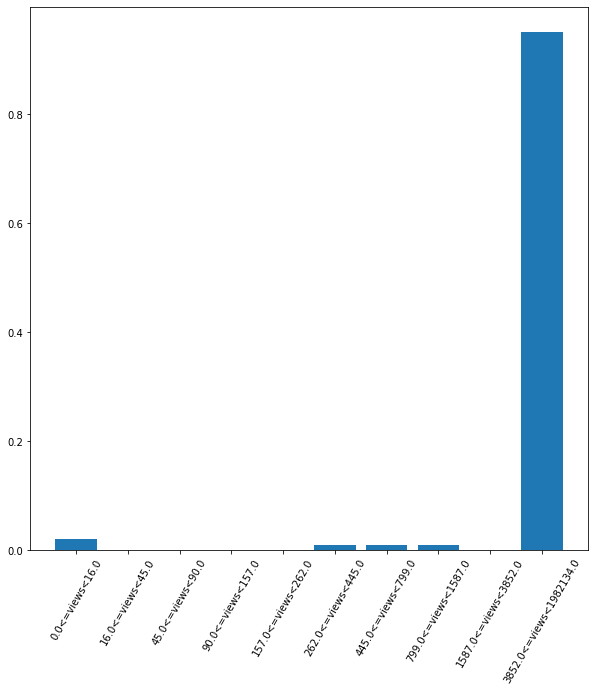

In [6]:
rank_limit = 100
sdf = df[(df["Algorithm"] == "AjioPremiumClusteringlr") & (df["clusterid"] == "cluster1")]
sdf = sdf[sdf["k"] == rank_limit]
bins_info_new = list(bins_info[(bins_info["Algorithm"] == "AjioPremiumClusteringlr") & (bins_info["clusterid"] == "cluster1")]["bins"].values)
num_bins = len(bins_info_new) - 1
binids = pd.DataFrame({"binid": list(range(num_bins))})
sdf = pd.merge(sdf, binids, on=["binid"], how="right")
sdf = sdf.sort_values(by=["binid"])
sdf["count"] = sdf["count"].fillna(0)
sdf["k"] = sdf["k"].fillna(rank_limit)
sdf["x"] = [f"{bins_info_new[i]}<=views<{bins_info_new[i+1]}" for i in range(len(bins_info_new)-1)]
sdf["y"] = sdf["count"]/sdf["k"]
plt.figure(figsize=(10,10))
plt.xticks(rotation=60)
plt.bar(sdf["x"],sdf["y"])
print(f"k = {rank_limit}")
print(sdf[["x", "y", "count"]])

k = 1000
                         x      y  count
0          0.0<=views<16.0  0.007      7
1         16.0<=views<45.0  0.006      6
2         45.0<=views<90.0  0.007      7
3        90.0<=views<157.0  0.006      6
4       157.0<=views<262.0  0.008      8
5       262.0<=views<445.0  0.006      6
6       445.0<=views<799.0  0.004      4
7      799.0<=views<1587.0  0.003      3
8     1587.0<=views<3852.0  0.005      5
9  3852.0<=views<1982134.0  0.948    948


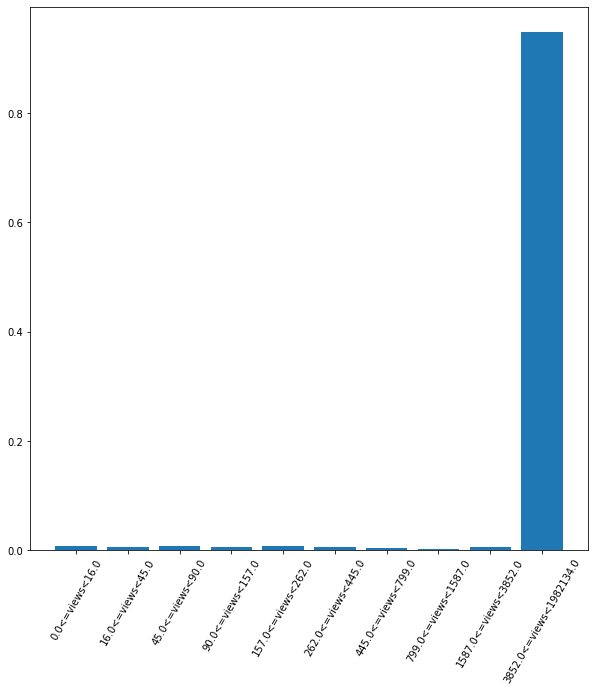

In [7]:
rank_limit = 1000
sdf = df[(df["Algorithm"] == "AjioPremiumClusteringlr") & (df["clusterid"] == "cluster1")]
sdf = sdf[sdf["k"] == rank_limit]
bins_info_new = list(bins_info[(bins_info["Algorithm"] == "AjioPremiumClusteringlr") & (bins_info["clusterid"] == "cluster1")]["bins"].values)
num_bins = len(bins_info_new) - 1
binids = pd.DataFrame({"binid": list(range(num_bins))})
sdf = pd.merge(sdf, binids, on=["binid"], how="right")
sdf = sdf.sort_values(by=["binid"])
sdf["count"] = sdf["count"].fillna(0)
sdf["k"] = sdf["k"].fillna(rank_limit)
sdf["x"] = [f"{bins_info_new[i]}<=views<{bins_info_new[i+1]}" for i in range(len(bins_info_new)-1)]
sdf["y"] = sdf["count"]/sdf["k"]
plt.figure(figsize=(10,10))
plt.xticks(rotation=60)
plt.bar(sdf["x"],sdf["y"])
print(f"k = {rank_limit}")
print(sdf[["x", "y", "count"]])

k = 5000
                         x       y  count
0          0.0<=views<16.0  0.0076     38
1         16.0<=views<45.0  0.0058     29
2         45.0<=views<90.0  0.0082     41
3        90.0<=views<157.0  0.0052     26
4       157.0<=views<262.0  0.0066     33
5       262.0<=views<445.0  0.0068     34
6       445.0<=views<799.0  0.0044     22
7      799.0<=views<1587.0  0.0064     32
8     1587.0<=views<3852.0  0.0128     64
9  3852.0<=views<1982134.0  0.9362   4681


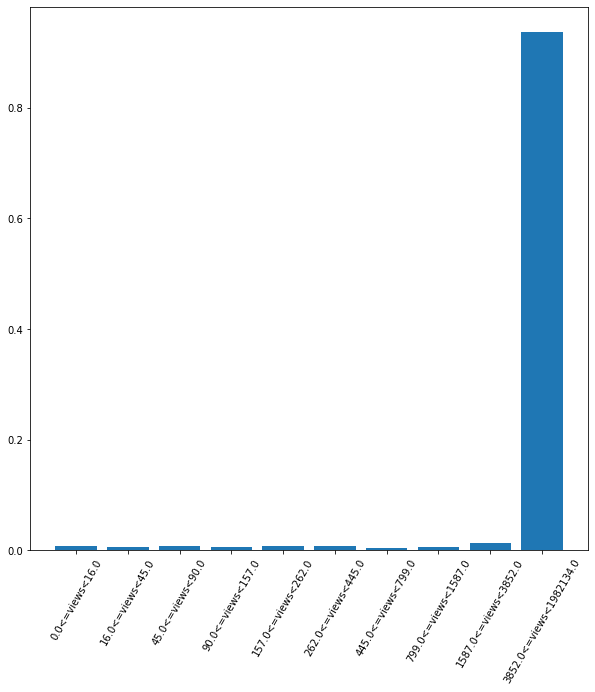

In [8]:
rank_limit = 5000
sdf = df[(df["Algorithm"] == "AjioPremiumClusteringlr") & (df["clusterid"] == "cluster1")]
sdf = sdf[sdf["k"] == rank_limit]
bins_info_new = list(bins_info[(bins_info["Algorithm"] == "AjioPremiumClusteringlr") & (bins_info["clusterid"] == "cluster1")]["bins"].values)
num_bins = len(bins_info_new) - 1
binids = pd.DataFrame({"binid": list(range(num_bins))})
sdf = pd.merge(sdf, binids, on=["binid"], how="right")
sdf = sdf.sort_values(by=["binid"])
sdf["count"] = sdf["count"].fillna(0)
sdf["k"] = sdf["k"].fillna(rank_limit)
sdf["x"] = [f"{bins_info_new[i]}<=views<{bins_info_new[i+1]}" for i in range(len(bins_info_new)-1)]
sdf["y"] = sdf["count"]/sdf["k"]
plt.figure(figsize=(10,10))
plt.xticks(rotation=60)
plt.bar(sdf["x"],sdf["y"])
print(f"k = {rank_limit}")
print(sdf[["x", "y", "count"]])

k = 10000
                         x       y  count
0          0.0<=views<16.0  0.0040     40
1         16.0<=views<45.0  0.0030     30
2         45.0<=views<90.0  0.0044     44
3        90.0<=views<157.0  0.0030     30
4       157.0<=views<262.0  0.0036     36
5       262.0<=views<445.0  0.0042     42
6       445.0<=views<799.0  0.0041     41
7      799.0<=views<1587.0  0.0078     78
8     1587.0<=views<3852.0  0.0208    208
9  3852.0<=views<1982134.0  0.9451   9451


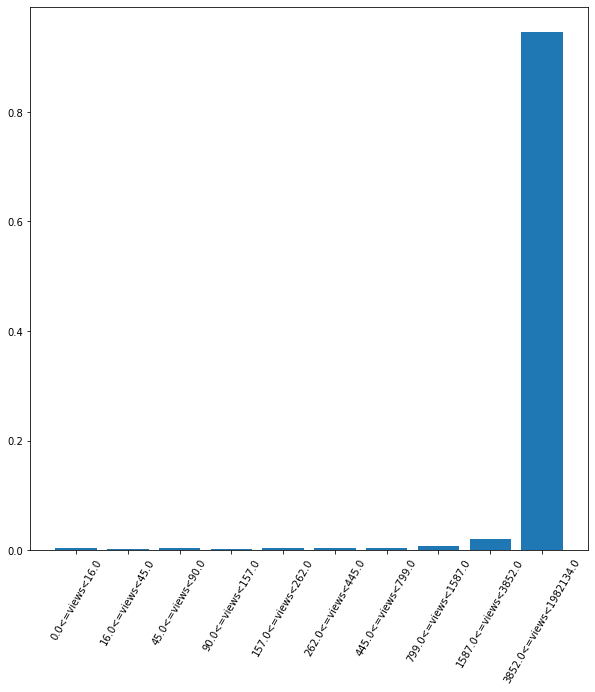

In [9]:
rank_limit = 10000
sdf = df[(df["Algorithm"] == "AjioPremiumClusteringlr") & (df["clusterid"] == "cluster1")]
sdf = sdf[sdf["k"] == rank_limit]
bins_info_new = list(bins_info[(bins_info["Algorithm"] == "AjioPremiumClusteringlr") & (bins_info["clusterid"] == "cluster1")]["bins"].values)
num_bins = len(bins_info_new) - 1
binids = pd.DataFrame({"binid": list(range(num_bins))})
sdf = pd.merge(sdf, binids, on=["binid"], how="right")
sdf = sdf.sort_values(by=["binid"])
sdf["count"] = sdf["count"].fillna(0)
sdf["k"] = sdf["k"].fillna(rank_limit)
sdf["x"] = [f"{bins_info_new[i]}<=views<{bins_info_new[i+1]}" for i in range(len(bins_info_new)-1)]
sdf["y"] = sdf["count"]/sdf["k"]
plt.figure(figsize=(10,10))
plt.xticks(rotation=60)
plt.bar(sdf["x"],sdf["y"])
print(f"k = {rank_limit}")
print(sdf[["x", "y", "count"]])

### Reformat and paste in excel

In [10]:
binnedData = pq.ParquetDataset("/data/Archive/plp/bhavesh/experiments/ajioplp_2023-04-17/AnalysisParquet/binnedData", fs).read().to_pandas()
num_bins = 10

In [28]:
binids = pd.DataFrame({"binid": list(range(10))})
binids["key"] = 1
binnedData["key"] = 1
df = pd.merge(binnedData, binids, on=["key"]).drop(columns=["key"])
df["count"] = df["count"].fillna(0.0)

An error was encountered:
Invalid status code '404' from http://10.144.97.194:8999/sessions/634 with error payload: "Session '634' not found."


In [13]:
df = df[df["binid"] != 10.0]
df["percentile_lower_bound"] = [f"{int(i)*(100/num_bins)}%" for i in df["binid"].values]
df["percentile_upper_bound"] = [f"{(int(i)+1)*(100/num_bins)}%" for i in df["binid"].values]
df["fraction"] = df["count"]/df["k"]
df = df[["Algorithm", "clusterid", "k", "percentile_lower_bound", "percentile_upper_bound", "count", "fraction"]]

In [14]:
df.to_csv("binnedDataAnalysis.csv", index=False)